# **`flygym`-MuJoCo tutorial**: Complex terrain

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_terrain.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In [ ]:
#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym

Installing flygym
  Preparing metadata (setup.py) ... done
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Checking that the flygym installation succeeded...


---

We have implemented slightly more complex terrain types. You can read more about it [here](https://nely-epfl.github.io/flygym/terrain/index.html).

 <img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/terrain.jpg" alt="Terrain types" width="800"> 


First, we define a `load_fly` helper function to load and configure a NeuroMechFly model. This is not critical and you don't have to understand it.

In [ ]:
#@title Define NeuroMechFly loader

import yaml
import numpy as np
import matplotlib.pyplot as plt
from dm_control import mjcf
from flygym.util.data import mujoco_groundwalking_model_path
from flygym.util.data import default_pose_path
from flygym.util.config import all_leg_dofs

def load_fly():
    # Load NMF model
    model = mjcf.from_path(mujoco_groundwalking_model_path)
    with open(default_pose_path) as f:
        init_pose = {k: np.deg2rad(v)
                        for k, v in yaml.safe_load(f)['joints'].items()}
    init_pose = {k: v for k, v in init_pose.items() if k in all_leg_dofs}

    # Set all bodies to default position (joint angle) even if the
    # joint is unactuated
    for body in model.find_all('body'):
        if (key := f'joint_{body.name}') in init_pose:
            if body.name.endswith('_yaw'):
                rot_axis = [1, 0, 0]
            elif body.name.endswith('_roll'):
                rot_axis = [0, 0, 1]
            else:    # pitch
                rot_axis = [0, 1, 0]
            # replace hardcoded quaternion with axis-angle
            del body.quat
            body.axisangle = [*rot_axis, init_pose[key]]
    
    return model

We can create a 'gapped' environment:

(-0.5, 319.5, 239.5, -0.5)

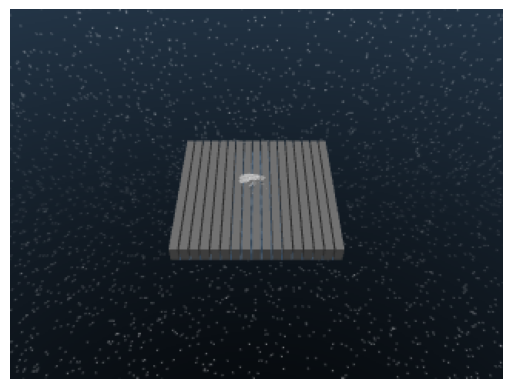

In [ ]:
from flygym.terrain.mujoco_terrain import GappedTerrain

gapped = GappedTerrain()
model = load_fly()
gapped.spawn_entity(model, rel_pos=(0, 0, 600), rel_angle=(0, 1, 0, 0.1))
physics = mjcf.Physics.from_mjcf_model(gapped.arena)
plt.imshow(physics.render())
plt.axis('off')

We can also create a 'blocks' environment:

(-0.5, 319.5, 239.5, -0.5)

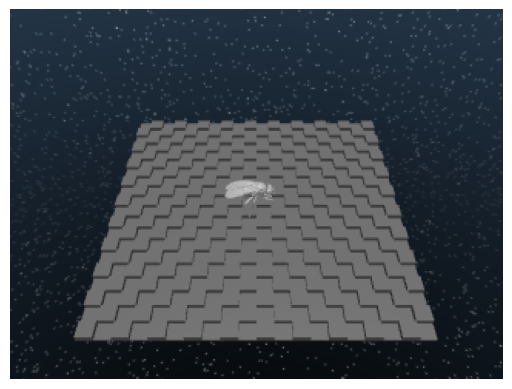

In [ ]:
from flygym.terrain.mujoco_terrain import ExtrudingBlocksTerrain

box = ExtrudingBlocksTerrain()
model = load_fly()
box.spawn_entity(model, rel_pos=(0, 0, 600), rel_angle=(0, 1, 0, 0.1))
physics = mjcf.Physics.from_mjcf_model(box.arena)
plt.imshow(physics.render())
plt.axis('off')

Of course, parameters such gap width, depth, and block size can configured. See the [MuJoCo terrain API reference](https://nely-epfl.github.io/flygym/terrain/mujoco.html) for details.